In [1]:
import pandas as pd

In [4]:
df=pd.read_csv("/content/api_source.csv")

In [5]:
df.head()

,txn_id,utr,amount,txn_date,status
0,1,LEWCTMBSBPCC,1299,2025-11-03,SUCCESS
1,2,P4DHW8UN9B5K,299,2025-10-26,SUCCESS
2,3,EDK4FUWMTCBG,999,2025-11-03,SUCCESS
3,4,XPLUQK3YHUS6,999,2025-10-29,SUCCESS
4,5,ZK9DP2ERBX2U,1299,2025-11-02,SUCCESS


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   txn_id    80 non-null     int64 
 1   utr       80 non-null     object
 2   amount    80 non-null     int64 
 3   txn_date  80 non-null     object
 4   status    80 non-null     object
dtypes: int64(2), object(3)
memory usage: 3.3+ KB


In [8]:
import numpy as np

In [9]:
api_path="/content/api_source.csv"

In [10]:
bank_path="/content/bank_settlement.csv"

In [11]:
api=pd.read_csv(api_path,dtype=str)

In [12]:
bank=pd.read_csv(bank_path,dtype=str)

In [13]:
api.columns = api.columns.str.strip()
bank.columns = bank.columns.str.strip()

In [14]:
def ensure_col(df, name, alternatives):
    for a in [name] + alternatives:
        if a in df.columns:
            df.rename(columns={a: name}, inplace=True)
            return True
    return False


In [15]:

ensure_col(api, "txn_id", ["txnid", "id"])
ensure_col(api, "utr", ["UTR", "utr_no", "utrnum"])
ensure_col(api, "amount", ["amt", "value"])
ensure_col(api, "txn_date", ["transaction_date", "date", "txnDate"])
ensure_col(api, "status", ["txn_status", "state"])


True

In [16]:
ensure_col(bank, "txn_id", ["txnid", "id"])
ensure_col(bank, "utr", ["UTR", "utr_no", "utrnum"])
ensure_col(bank, "amount", ["amt", "value"])
ensure_col(bank, "txn_date", ["transaction_date", "date", "txnDate"])
ensure_col(bank, "status", ["txn_status", "state"])
ensure_col(bank, "settlement_date", ["settlementDate", "settlement_dt", "settlement"])

True

In [17]:
api = api[["txn_id","utr","amount","txn_date","status"]].copy()
bank = bank[[c for c in ["txn_id","utr","amount","txn_date","status","settlement_date"] if c in bank.columns]].copy()

In [20]:
for df in (api, bank):
    if "txn_id" in df.columns:
        df["txn_id"] = df["txn_id"].astype(str).str.strip()
    if "utr" in df.columns:
        df["utr"] = df["utr"].astype(str).str.strip().replace({"nan":np.nan})
    if "amount" in df.columns:
        df["amount"] = pd.to_numeric(df["amount"].astype(str).str.replace(",","").str.strip(), errors="coerce")
    if "status" in df.columns:
        df["status"] = df["status"].astype(str).str.strip().str.lower().replace({"nan":np.nan})
    if "txn_date" in df.columns:
        df["txn_date"] = pd.to_datetime(df["txn_date"], infer_datetime_format=True, errors="coerce")

if "settlement_date" in bank.columns:
    bank["settlement_date"] = pd.to_datetime(bank["settlement_date"], infer_datetime_format=True, errors="coerce")
else:
    bank["settlement_date"] = pd.NaT
api["source"] = "api"
bank["source"] = "bank"

/tmp/ipython-input-3622257059.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["txn_date"] = pd.to_datetime(df["txn_date"], infer_datetime_format=True, errors="coerce")
/tmp/ipython-input-3622257059.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["txn_date"] = pd.to_datetime(df["txn_date"], infer_datetime_format=True, errors="coerce")
/tmp/ipython-input-3622257059.py:14: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata

In [21]:
merged = pd.merge(api, bank, on="txn_id", how="outer", suffixes=("_api", "_bank"), indicator=True)

merged["utr_api"] = merged.get("utr_api", merged.get("utr_api", merged.get("utr")))
merged["utr_bank"] = merged.get("utr_bank", merged.get("utr_bank", merged.get("utr")))

In [22]:
def date_only(dt):
    if pd.isnull(dt):
        return pd.NaT
    return pd.to_datetime(dt).normalize()

In [23]:
merged["txn_date_api"] = pd.to_datetime(merged.get("txn_date_api"), errors="coerce")
merged["txn_date_bank"] = pd.to_datetime(merged.get("txn_date_bank"), errors="coerce")

In [ ]:
def date_only(dt):
  if pd.isnull(dt):
    return pd.NaT
  return pd.to_datetime(dt).normalize()

In [24]:
merged["txn_date_api_d"] = merged["txn_date_api"].dt.normalize()
merged["txn_date_bank_d"] = merged["txn_date_bank"].dt.normalize()

In [25]:
cond_utr_equal = (merged["utr_api"].fillna("") == merged["utr_bank"].fillna(""))
cond_date_equal = merged["txn_date_api_d"].notna() & merged["txn_date_bank_d"].notna() & (merged["txn_date_api_d"] == merged["txn_date_bank_d"])
cond_amount_equal = merged["amount_api"].notna() & merged["amount_bank"].notna() & (np.isclose(merged["amount_api"].fillna(0), merged["amount_bank"].fillna(0)))
cond_status_equal = merged["status_api"].fillna("").str.lower() == merged["status_bank"].fillna("").str.lower()

In [26]:
merged["category"] = "unclassified"
merged.loc[cond_utr_equal & cond_date_equal & cond_amount_equal, "category"] = "exact_match"
merged.loc[cond_utr_equal & cond_date_equal & ~cond_amount_equal & ~(merged["_merge"]!="both"), "category"] = "amount_mismatch"
merged.loc[cond_utr_equal & cond_date_equal & cond_amount_equal & ~cond_status_equal, "category"] = "status_mismatch"
merged.loc[merged["_merge"] == "left_only", "category"] = "missing_in_bank"
merged.loc[merged["_merge"] == "right_only", "category"] = "missing_in_api"

In [28]:
categories = ["exact_match","amount_mismatch","status_mismatch","missing_in_bank","missing_in_api","unclassified"]
for cat in categories:
    dfc = merged[merged["category"] == cat].copy()
    if not dfc.empty:
        dfc.to_csv(f"/content/sample_data{cat}.csv", index=False)

In [29]:
total = len(merged)
summary = pd.DataFrame({
    "category": categories,
    "count": [len(merged[merged["category"]==c]) for c in categories]
})

In [35]:
summary["match_rate(%)"] = (summary["count"] / total * 100).round(2)
summary.to_csv("/content/summary.csv", index=False)

In [37]:
import os

exact = merged[merged["category"]=="exact_match"].copy()
exact["settlement_date"] = pd.to_datetime(exact.get("settlement_date"), errors="coerce")
exact["TAT_days"] = (exact["settlement_date"] - exact["txn_date_api"]).dt.days
tat = exact["TAT_days"].dropna()

output_dir = "/content"
os.makedirs(output_dir, exist_ok=True)

if not tat.empty:
    tat_desc = tat.describe().to_frame().T
    tat_desc.to_csv(f"{output_dir}/tat_distribution.csv", index=False)
else:
    pd.DataFrame([{"count":0}]).to_csv(f"{output_dir}/tat_distribution.csv", index=False)

In [38]:
mismatch_causes = {
    "amount_mismatch": len(merged[merged["category"]=="amount_mismatch"]),
    "status_mismatch": len(merged[merged["category"]=="status_mismatch"]),
    "missing_in_bank": len(merged[merged["category"]=="missing_in_bank"]),
    "missing_in_api": len(merged[merged["category"]=="missing_in_api"])
}

In [41]:
top3 = sorted(mismatch_causes.items(), key=lambda x: x[1], reverse=True)[:3]
pd.DataFrame(top3, columns=["cause","count"]).to_csv("/content/top3_mismatch_causes.csv", index=False)


Visualization of Data

In [42]:
import matplotlib.pyplot as plt


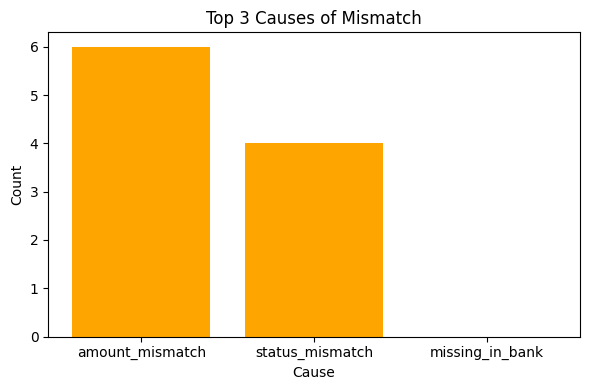

In [43]:
top3 = pd.read_csv("/content/top3_mismatch_causes.csv")
plt.figure(figsize=(6,4))
plt.bar(top3["cause"], top3["count"], color='orange')
plt.title("Top 3 Causes of Mismatch")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
